In [21]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

,prop,other_resp,other_prop,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,50,50,50,43000,26,60,31000,20,4.2,3.0,2.8,50
1,50,20,20,12000,7,20,38000,20,1.9,4.4,2.9,50
2,120,50,80,88000,50,20,69000,12,3.3,3.8,3.4,80
3,50,50,50,24000,50,60,26000,14,3.6,3.8,2.6,50
4,100,50,50,137000,24,60,43000,4,3.6,2.5,2.7,100


<Figure size 432x288 with 0 Axes>

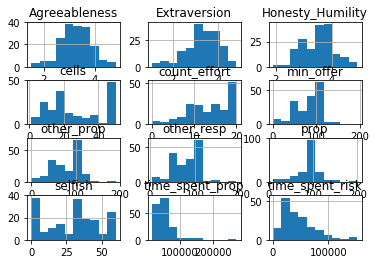

<Figure size 432x288 with 0 Axes>

In [22]:
from utils.preprocessing import df_to_xy
#fix rnd seed
np.random.seed(7)

MAX_GAIN = 200

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")

# df = df[['time_spent_risk', 'cells', 'selfish', 'time_spent_prop', 'count_effort',
#          'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

# MAX_ACCEPTABLE_MIN_OFFER = 150
# df = df[df['min_offer'] <= MAX_ACCEPTABLE_MIN_OFFER]



#print(df[50:])

# Show head and histograms
display(df.head())
df.hist()

# Plot sample figure for min_offers
plt.figure()

#x = range(0, len(df['prop']))
#x1 = df['min_offer']

#plt.plot(x, x1)

In [23]:
# sb.pairplot(df, x_vars=('prop','other_resp','other_prop'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
# sb.pairplot(df, x_vars=('cells', 'selfish','count_effort'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
# sb.pairplot(df, x_vars=('Honesty_Humility', 'Extraversion','Agreeableness'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
# sb.pairplot(df, x_vars=('time_spent_prop', 'time_spent_risk'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')

In [24]:
#manual ablation
#df = df.drop(columns=['cells','selfish','count_effort','Honesty_Humility','Extraversion','Agreeableness','time_spent_risk','time_spent_prop'])

In [25]:
from sklearn.linear_model import LinearRegression
# Split into inputs and oututs
x = df.iloc[:, :-1].values

y = df.iloc[:, -1:].values
NB_FEATURES = x.shape[1]
NORMALISE_DATA = True


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5, random_state = 0)
#print(xTrain)
#print(yTrain)


In [26]:
@np.vectorize
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

@np.vectorize
def sigmoid1024(x):
    base = 2000.0**2
    return (base**x/(base**x + 1))

@np.vectorize
def sigmoid128(x):
    return (128**x/(128**x + 1))


@np.vectorize
def loss(x):
    x = (x) / 40
    return (1 - sigmoid1024(x) *  np.cos(x/np.pi))
    #return 1 - gain(x+24)

def gain(x):
    return 1 - loss(x)

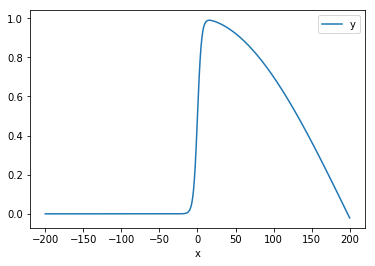

In [27]:
x = np.linspace(-200, 200, 1000)
y = gain(x)

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

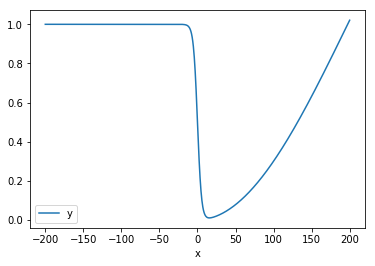

In [28]:
y = loss(x)

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

In [29]:
from utils.data_augmentation import DACombine

In [30]:
from models.deep import keras_linear_regression, keras_model, loss_tf, gain_tf, KerasModel

**Metrics**

In [31]:
from models.metrics import gain_mean

**Model: No data Augmentation**

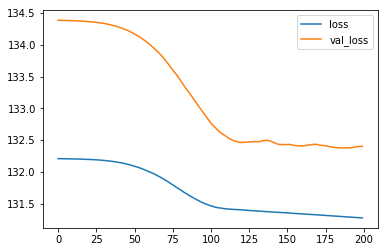

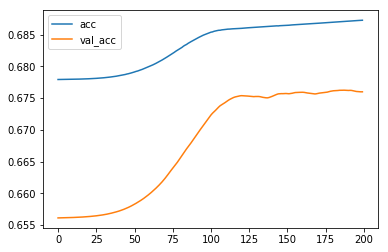

In [32]:
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=60, epochs=200)
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
split = int(xTrain.shape[1] * 0.75)
#xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain, yTrain, size=1024, distance=10)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'),  validation_split=0.25, verbose=0)

#print(history.history)

loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  2.6245608


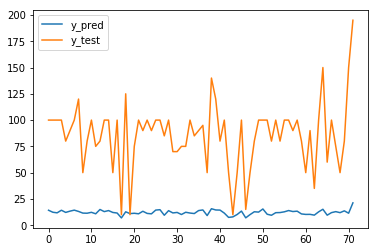

In [33]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

**Model with data augmentation**

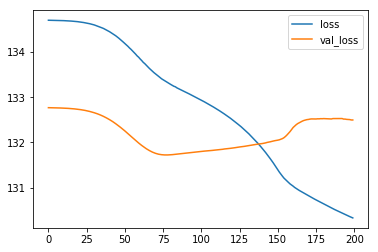

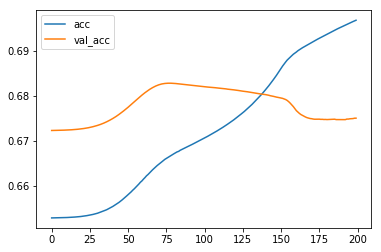

In [34]:
#sci-kit like training
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=60, epochs=200)
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'),  validation_data=(xVal, yVal), verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  10.258282


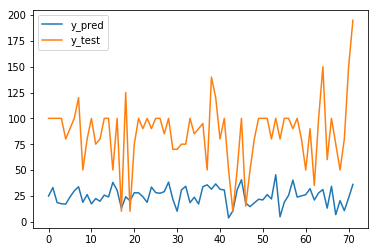

In [35]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

** Model using _mse_ loss and data augmentation**

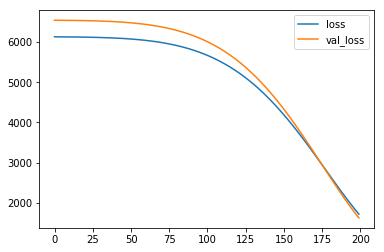

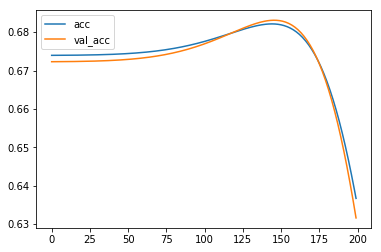

In [36]:
#sci-kit like training
model = KerasModel(loss='mse', metrics=[gain_tf], batch_size=60, epochs=200)
da = DACombine()
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_data=(xVal, yVal))
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  11.454389


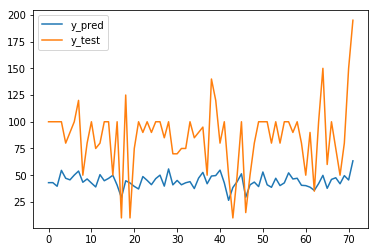

In [37]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

**AcceptanceModel**

In [38]:
from models import AcceptanceModel

gain_mean:  85.27777777777777


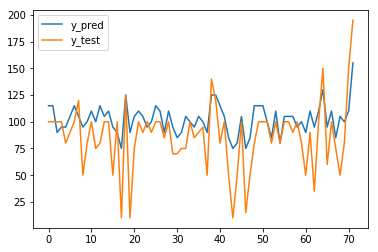

In [39]:
from sklearn.ensemble.bagging import BaggingRegressor, BaggingClassifier, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import NuSVC, SVC, LinearSVC, LinearSVR, SVR, NuSVR

#LinearSVR, zero_one=True: 87
#SVR, zero_one=True: 70

model = AcceptanceModel(LinearSVR(loss='epsilon_insensitive', ), step=5, zero_one=True)
#model = AcceptanceModel(KerasModel(epochs=300), zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yTrain_[yTrain_ < 50] = 50

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

gain_mean:  77.08333333333333


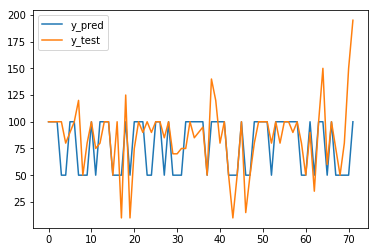

In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1', solver='saga', multi_class='ovr')
model.fit(xTrain_, yTrain_.ravel())

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))